## 1. 라이브러리 임포트하기

In [308]:
from konlpy.tag import Okt

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.text import Tokenizer

import pandas as pd
import numpy
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager

## 2. 데이터셋 불러오기

In [309]:
train_set = pd.read_csv("./3_Data analysis_A.csv")

In [310]:
train_set

,달,날짜,기사 제목,감정 수치
0,한겨레,20170510,보수 10년 퇴행 바로잡고 미완의 개혁 진전시킬 기회,0
1,한겨레,20170510,한겨레 사설 문재인 대통령 국민과 함께 나라다운 나라 만들길,1
2,한겨레,20170510,미 언론 한국 시민혁명 대북압박 트럼프에 도전,0
3,한겨레,20170510,한겨레 사설 통합과 공존 앞세운 문 대통령의 취임사,1
4,한겨레,20170510,한겨레 사설 이낙연 총리 임종석 실장 인선에 거는 기대,1
...,...,...,...,...
5708,동아일보,20211122,사설 반값아파트 기본주택 역세권첫집 모두 현실성 의문이다,-1
5709,동아일보,20211124,사설 이재명 노동이사제 공기업 철밥통만 강화해줄 것,-2
5710,동아일보,20211126,신문과 놀자 주니어를 위한 사설 따라잡기 아슬아슬한 위드 코로나,0
5711,동아일보,20211127,사설 李 탄소세로 30조∼64조 이러다간 제조업 뿌리 흔들릴 것,0


## 3. 모델 제작을 위한 데이터 전처리

okt를 이용하여 문장을 단어 단위로 분리하고, 한국어에서의 불용어를 제거한다.
[원형 불용어 목록 출처](https://wikidocs.net/94600)

또한, 키워드(사설)나 검색한 언론사명이 제목에 다수 포함될 수 있어 이 또한 불용어에 추가하였다.

In [311]:
okt = Okt()
old = []
stopword = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '사설', '칼럼', '한겨레', '동아', '경향']
#검색 키워드나 신문사명 추가
for idx, title in enumerate(train_set['기사 제목']):
    Xtemp = []
    Xtemp = okt.morphs(title)
    Xtemp = [word for word in Xtemp if not word in stopword]
    if (len(Xtemp) >= 8): #단어가 8개 미만 존재하는 문장은 모델링에 있어 부정확할 확률이 있을 것으로 판단
        old.append([train_set['감정 수치'][idx], len(Xtemp), Xtemp]) #감정 수치, 문장의 단어 갯수, 단어

In [312]:
old

[[0, 9, ['보수', '10년', '퇴행', '바로잡고', '미완', '개혁', '진전', '시킬', '기회']],
 [1, 8, ['문재인', '대통령', '국민', '함께', '나라', '다운', '나라', '만들길']],
 [0, 8, ['미', '언론', '한국', '시민혁명', '대북', '압박', '트럼프', '도전']],
 [1, 9, ['비', '검찰', '민정', '수석', '발탁', '검찰', '개혁', '마지막', '기회']],
 [-1, 8, ['비정규직', '해결', '물꼬', '튼', '인천공항', '1만', '명', '전환']],
 [1, 9, ['민주', '새', '정부', '꾸리기', '전', '떡', '고물', '놓고', '다투나']],
 [1, 10, ['석탄', '발전', '셧다운', '으로', '첫', '발', '뗀', '미세먼지', '30', '감축']],
 [-1,
  12,
  ['속', '으로', '중앙', '일보', '미국', '하원', '대북', '제재', '법', '통과', '비교', '해']],
 [-1, 8, ['재벌', '개혁', '신호탄', '올린', '김상조', '공정', '위원장', '발탁']],
 [0, 8, ['돈', '봉투', '만찬', '감찰', '검찰', '개혁', '으로', '이어져야']],
 [0, 8, ['아직도', '진실', '밝히지', '못', '5', '18', '광주', '항쟁']],
 [0, 10, ['사드', '난제', '국회', '비준', '동의', '지렛대', '로', '미', '중', '설득']],
 [1, 9, ['소신', '돋보인', '헌재', '검찰', '인사', '개혁', '기대', '부응', '하길']],
 [1, 8, ['개헌', '추진', '국민', '뜻', '폭넓게', '반영', '해야', '성공한다']],
 [0, 12, ['김동연', '장하', '성', '경제', '팀', '금수', '저', '흙', '수저', '구조', '깨', '라']],
 [

단어의 갯수가 같은 문장들을 분석하여 문장 길이에 대한 변인을 제거하였음.

데이터셋이 가장 많은 단어가 9개인 문장을 train할 data로 선택

<AxesSubplot:>

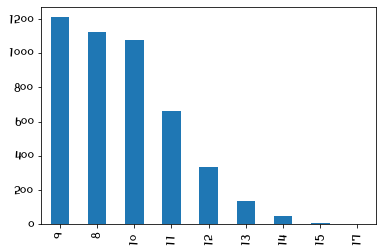

In [313]:
wordlen = pd.DataFrame()
wordlen['단어 갯수'] = [old[i][1] for i in range(len(old))]
wordlen['단어 갯수'].value_counts().plot(kind='bar')

In [314]:
emotional = []
new = []

for word_info in old:
    if word_info[1] == 9:
        emotional.append(word_info[0])
        new.append(word_info[2])

token = Tokenizer(num_words = len(new)*10)
token.fit_on_texts(new)
new = token.texts_to_sequences(new) #list type

In [315]:
new

[[184, 647, 935, 1563, 648, 5, 478, 936, 147],
 [224, 25, 383, 225, 1564, 25, 5, 649, 147],
 [185, 75, 9, 1565, 65, 1566, 1567, 384, 1568],
 [650, 937, 226, 25, 43, 5, 186, 938, 129],
 [60, 7, 227, 265, 130, 1, 651, 317, 385],
 [939, 66, 386, 1569, 1570, 1571, 67, 387, 99],
 [66, 388, 940, 652, 266, 267, 941, 148, 2],
 [268, 318, 942, 41, 389, 319, 479, 653, 480],
 [481, 943, 654, 269, 1572, 1573, 482, 187, 944],
 [320, 131, 12, 483, 655, 113, 188, 484, 2],
 [656, 390, 5, 189, 1574, 10, 945, 657, 190],
 [90, 270, 946, 190, 391, 1575, 149, 7, 132],
 [1576, 485, 1577, 270, 1578, 271, 82, 947, 1579],
 [392, 100, 7, 68, 393, 1580, 55, 15, 76],
 [394, 395, 191, 69, 948, 1581, 658, 16, 659],
 [660, 66, 486, 949, 272, 273, 1582, 1583, 1584],
 [43, 56, 4, 383, 225, 950, 192, 150, 487],
 [60, 7, 227, 265, 9, 83, 396, 317, 385],
 [151, 488, 321, 951, 489, 77, 193, 490, 1585],
 [60, 7, 227, 265, 661, 662, 952, 317, 1586],
 [17, 491, 953, 954, 955, 13, 1587, 103, 397],
 [13, 492, 1588, 91, 228, 16

단어의 갯수가 같은 문장들로 새롭게 데이터를 구축함.

list가 DataFrame으로 치환되었기에 문장에서의 감정을 가지는 단어의 어순 또한 변인 요소가 됨

In [316]:
newdf = pd.DataFrame()
for i in range(9):
    newdf['%d번째 단어' %i] = [new[j][i] for j in range(len(new))]
newdf['감정 수치'] = [emotional[i] for i in range(len(emotional))]

In [317]:
newdf

,0번째 단어,1번째 단어,2번째 단어,3번째 단어,4번째 단어,5번째 단어,6번째 단어,7번째 단어,8번째 단어,감정 수치
0,184,647,935,1563,648,5,478,936,147,0
1,224,25,383,225,1564,25,5,649,147,1
2,185,75,9,1565,65,1566,1567,384,1568,1
3,650,937,226,25,43,5,186,938,129,1
4,60,7,227,265,130,1,651,317,385,-1
...,...,...,...,...,...,...,...,...,...,...
1204,1221,1222,80,1391,643,3813,895,1542,3814,-2
1205,513,14,1,3815,3816,3817,638,728,80,1
1206,3818,1516,3819,520,1189,3820,900,59,3821,1
1207,900,59,3822,1469,594,3823,3824,126,382,-1


In [318]:
X = newdf.values[:, 0:9].astype(int)
Y_obj = newdf.values[:, 9].astype(int)

In [319]:
X

array([[ 184,  647,  935, ...,  478,  936,  147],
       [ 224,   25,  383, ...,    5,  649,  147],
       [ 185,   75,    9, ..., 1567,  384, 1568],
       ...,
       [3818, 1516, 3819, ...,  900,   59, 3821],
       [ 900,   59, 3822, ..., 3824,  126,  382],
       [1562,  311, 3825, ...,  199, 3827,  104]])

In [320]:
Y = [[0, 0, 0, 0, 0] for i in range(len(Y_obj))] 
#result state가 5개여서 새로운 0으로 찬 배열을 만든 후, 감정 상태에 따라 one-hot encoding을 진행함
#-2 ~ 2 사이의 state가 배열에서의 idx의 0~4로 전환됨

for i in range(len(Y_obj)):
    Y[i][Y_obj[i]+2] = 1
    
Y = numpy.array(Y)
Y

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]])

## 4. 모델링

3 class 이상에서의 분류를 목적으로 하기에, softmax 활성화 함수를 사용함.
은닉층을 적절히 추가하여 사용

In [321]:
from sklearn.model_selection import train_test_split 

seed = 0
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=seed)

In [322]:
model = Sequential() 
model.add(Dense(90, input_dim=9, activation='relu'))
model.add(Dense(5, activation='softmax')) #state가 5가지이므로 softmax 사용

In [323]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [324]:
model_dir = './model_save(1).'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

modelpath="./model_save/{epoch:02d}-{val_loss:.4f}.hdf5" 

# 모델 업데이트 및 저장
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

In [325]:
hist1 = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, verbose=2)

Epoch 1/100
23/23 - 0s - loss: 297.8161 - accuracy: 0.2124 - val_loss: 219.0751 - val_accuracy: 0.2707 - 469ms/epoch - 20ms/step
Epoch 2/100
23/23 - 0s - loss: 169.9599 - accuracy: 0.2634 - val_loss: 140.7734 - val_accuracy: 0.2335 - 57ms/epoch - 2ms/step
Epoch 3/100
23/23 - 0s - loss: 115.7122 - accuracy: 0.2428 - val_loss: 112.2813 - val_accuracy: 0.2397 - 57ms/epoch - 2ms/step
Epoch 4/100
23/23 - 0s - loss: 95.2643 - accuracy: 0.2676 - val_loss: 97.9251 - val_accuracy: 0.2355 - 55ms/epoch - 2ms/step
Epoch 5/100
23/23 - 0s - loss: 81.1142 - accuracy: 0.2786 - val_loss: 91.6485 - val_accuracy: 0.2603 - 62ms/epoch - 3ms/step
Epoch 6/100
23/23 - 0s - loss: 72.5376 - accuracy: 0.2897 - val_loss: 81.2131 - val_accuracy: 0.2293 - 56ms/epoch - 2ms/step
Epoch 7/100
23/23 - 0s - loss: 60.4800 - accuracy: 0.3145 - val_loss: 71.7233 - val_accuracy: 0.2417 - 61ms/epoch - 3ms/step
Epoch 8/100
23/23 - 0s - loss: 52.9628 - accuracy: 0.3021 - val_loss: 65.4336 - val_accuracy: 0.2748 - 61ms/epoch - 3

Epoch 67/100
23/23 - 0s - loss: 8.1920 - accuracy: 0.5448 - val_loss: 30.5495 - val_accuracy: 0.2603 - 75ms/epoch - 3ms/step
Epoch 68/100
23/23 - 0s - loss: 6.7921 - accuracy: 0.5641 - val_loss: 31.7793 - val_accuracy: 0.2500 - 76ms/epoch - 3ms/step
Epoch 69/100
23/23 - 0s - loss: 7.9073 - accuracy: 0.5490 - val_loss: 32.8900 - val_accuracy: 0.2459 - 86ms/epoch - 4ms/step
Epoch 70/100
23/23 - 0s - loss: 8.2641 - accuracy: 0.5393 - val_loss: 32.4996 - val_accuracy: 0.2727 - 58ms/epoch - 3ms/step
Epoch 71/100
23/23 - 0s - loss: 6.3361 - accuracy: 0.5724 - val_loss: 31.5312 - val_accuracy: 0.2541 - 56ms/epoch - 2ms/step
Epoch 72/100
23/23 - 0s - loss: 5.8645 - accuracy: 0.5752 - val_loss: 30.5608 - val_accuracy: 0.2521 - 77ms/epoch - 3ms/step
Epoch 73/100
23/23 - 0s - loss: 6.2713 - accuracy: 0.5752 - val_loss: 31.5079 - val_accuracy: 0.2748 - 82ms/epoch - 4ms/step
Epoch 74/100
23/23 - 0s - loss: 5.6660 - accuracy: 0.5821 - val_loss: 30.9076 - val_accuracy: 0.2521 - 72ms/epoch - 3ms/step


In [326]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 90)                900       
                                                                 
 dense_38 (Dense)            (None, 5)                 455       
                                                                 
Total params: 1,355
Trainable params: 1,355
Non-trainable params: 0
_________________________________________________________________


## 5. 모델링 평가

In [327]:
loss, acc = model.evaluate(x=X_test, y=Y_test, verbose=0) 
print("test dataset 평가 : Loss = {:.4f}".format(loss))      
print("test dataset 평가: Accuracy = {:.4f}".format(acc))  

test dataset 평가 : Loss = 31.3914
test dataset 평가: Accuracy = 0.2583


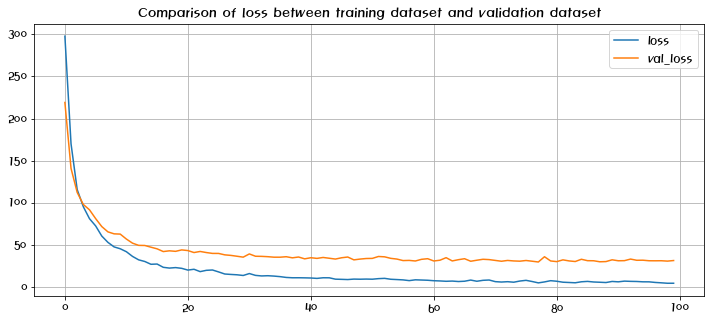

In [328]:
plt.figure(figsize=(12,5))
plt.title('Comparison of loss between training dataset and validation dataset', fontsize=14)
plt.plot(hist1.history['loss'])      
plt.plot(hist1.history['val_loss'])  
plt.legend(['loss','val_loss']) 
plt.grid()
plt.show()

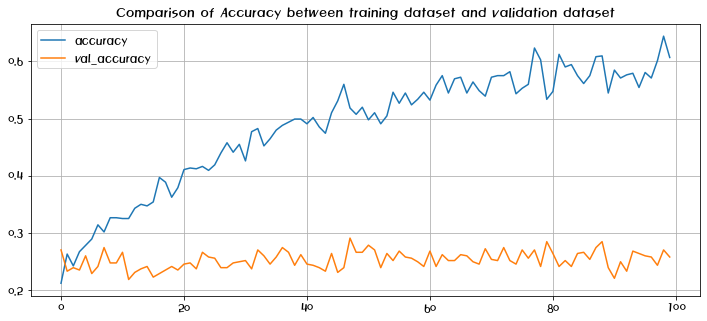

In [329]:
plt.figure(figsize=(12,5))
plt.title('Comparison of Accuracy between training dataset and validation dataset', fontsize=14)
plt.plot(hist1.history['accuracy'])     
plt.plot(hist1.history['val_accuracy']) 
plt.legend(['accuracy','val_accuracy'])
plt.grid()
plt.show()

## 6. 모델링 결과 분석

val_accurancy의 정확도가 상당히 떨어지고, 러닝 데이터와 테스트 데이터의 차이도 상당히 크다.
수치로 보았을 때, 문장 단어의 긍정 / 부정에 따른 유의미한 학습이 전혀 이뤄지지 않는 것으로 보인다.

예상되는 원인은 다음과 같다;
1. output을 고려하여 softmax 활성화함수를 사용하였으나, input의 변인이 9개이므로 충분한 은닉층이 구축되지 못했을 가능성이 있다.
2. 재구축한 자연어 처리가 기계가 이해할 수 없는 형태로, 가장 기본적인 형태인 Dense Layer만 사용하여 유의미한 learning이 이뤄지지 못했다.

다음 모델에서는 (1)번 원인을 수정해보고자 더 많은 은닉층과, 두 단계 혹은 세 단계 이상의 은닉층을 거치도록 설계해볼 것이다.